In [1]:
import numpy as np
import random
import geojson
import momepy
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import LineString, MultiLineString, Polygon
from tqdm import tqdm
from itertools import combinations

In [2]:
## load seattle street lines
path_to_file = 'wa.seattle.graph.edges.Ricky.geojson'
with open(path_to_file) as f:
    gj = geojson.load(f)
features = gj['features']

## load fremont area
lat_max = 47.661424
lat_min = 47.658118
lat_min = 47.660118
long_left = -122.360829
long_right = -122.355055
long_right = -122.357055
fremont = Polygon(
    [
        [long_left, lat_max], 
        [long_right, lat_max], 
        [long_right, lat_min], 
        [long_left, lat_min]
    ]
)
fremont

## subset lines in fremont
multi_lines = []
for i in tqdm(range(len(features))):
    line = LineString(features[i]['geometry']['coordinates'])
    if line.intersects(fremont):
        multi_lines.append(line)
multi_lines_df = gpd.GeoDataFrame(multi_lines, columns=['geometry'],crs=4326)
multi_lines_df.head()

100%|████████████████████████████████| 267710/267710 [00:04<00:00, 55193.92it/s]


,geometry
0,"LINESTRING (-122.35729 47.65961, -122.35725 47..."
1,"LINESTRING (-122.35729 47.65961, -122.35738 47..."
2,"LINESTRING (-122.36080 47.66050, -122.36127 47..."
3,"LINESTRING (-122.36080 47.66050, -122.36081 47..."
4,"LINESTRING (-122.35893 47.66149, -122.35897 47..."


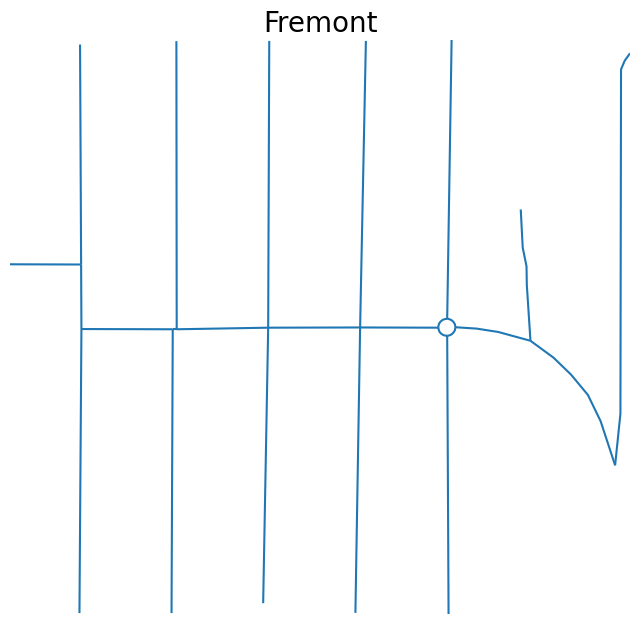

In [3]:
## visualization
f, ax = plt.subplots(1, figsize=(8,8))
ax = multi_lines_df.plot(ax=ax)
ax.set_title('Fremont', fontsize=20)
ax.set_axis_off()
ax.margins(0)
ax.apply_aspect()
pass

/opt/anaconda3/lib/python3.8/site-packages/momepy/utils.py:252: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length


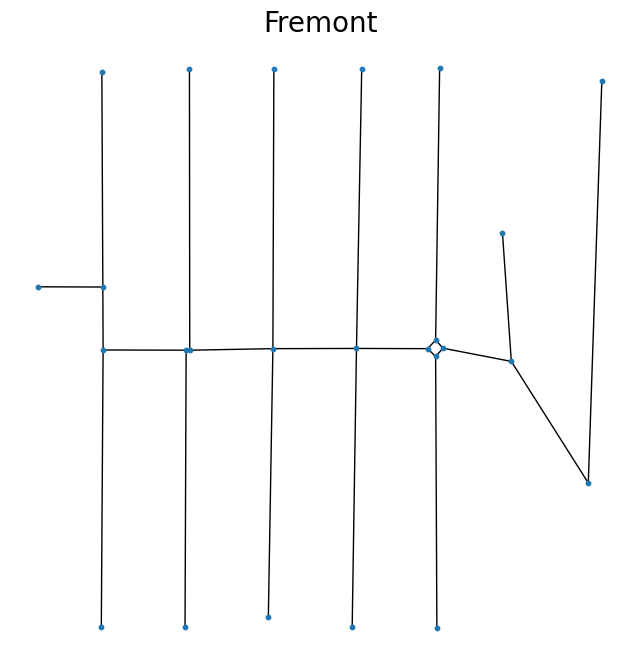

In [25]:
## build graph
graph = momepy.gdf_to_nx(multi_lines_df, approach='primal')
plt.figure(figsize=(8,8))
plt.title('Fremont', fontsize=20)
nx.draw(graph, {n:[n[0], n[1]] for n in list(graph.nodes)}, node_size=10)

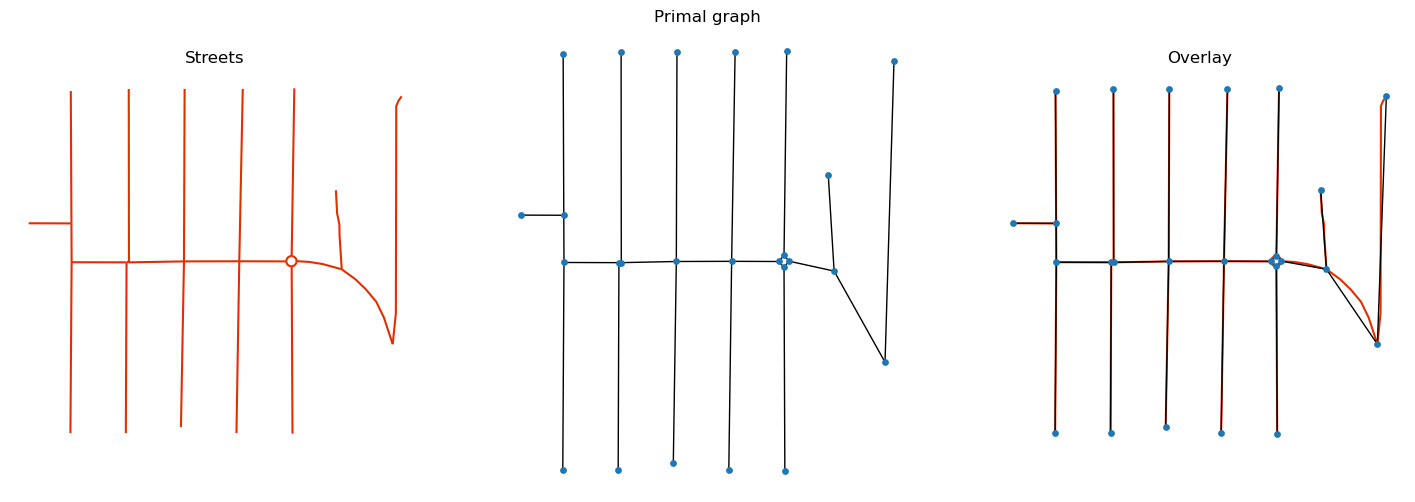

In [28]:
f, ax = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
multi_lines_df.plot(color='#e32e00', ax=ax[0])
for i, facet in enumerate(ax):
    facet.set_title(("Streets", "Primal graph", "Overlay")[i])
    facet.axis("off")
nx.draw(graph, {n:[n[0], n[1]] for n in list(graph.nodes)}, ax=ax[1], node_size=15)
multi_lines_df.plot(color='#e32e00', ax=ax[2], zorder=-1)
nx.draw(graph, {n:[n[0], n[1]] for n in list(graph.nodes)}, ax=ax[2], node_size=15)

### Add or Remove Edges

In [6]:
G_add = graph.copy()
G_remove = graph.copy()
G_add.add_edge((-122.357192, 47.661433), (-122.357847, 47.660159))
G_remove.remove_edge(list(G_remove.edges)[0][0], list(G_remove.edges)[0][1])

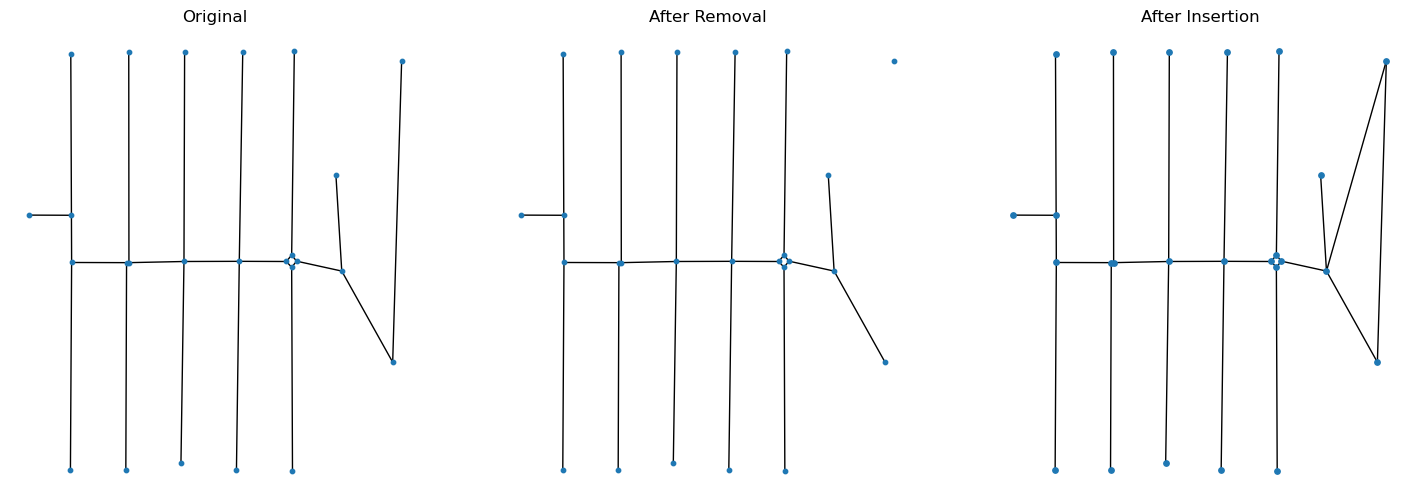

In [7]:
f, ax = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
for i, facet in enumerate(ax):
    facet.set_title(("Original", "After Removal", "After Insertion")[i])
    facet.axis("off")
nx.draw(graph, {n:[n[0], n[1]] for n in list(graph.nodes)}, ax=ax[0], node_size=10)
nx.draw(G_remove, {n:[n[0], n[1]] for n in list(graph.nodes)}, ax=ax[1], node_size=10)
nx.draw(G_add, {n:[n[0], n[1]] for n in list(graph.nodes)}, ax=ax[2], node_size=15)

In [8]:
def addEdge(G,n,seed=816):
    
    """
    Add n number of edges from graph
    
    - G: graph network
    - n: number of edges to add
    
    """
    
    # random see
    np.random.seed(seed)
    
    # extract all edges
    edges = list(G.edges())
    nodes = list(G.nodes())
    nodes_comb = list(combinations(nodes, 2))
    nodes_comb = [c for c in nodes_comb if n not in edges]
        
    # loop n times
    for i in range(n):
        
        # random shuffule edges
        random.shuffle(nodes_comb)
        
        # insert the node comb
        G.add_edge(nodes_comb[0][0], nodes_comb[0][1])
        
        # remove the first node comb from the list
        nodes_comb.pop(0)

In [9]:
def delEdge(G, n, seed=816):
    
    """
    Delete n number of edges from graph
    
    - G: graph network
    - n: number of edges to delete
    
    """
    
    # random see
    np.random.seed(seed)
    
    # extract all edges
    edges = list(G.edges())
        
    # loop n times
    for i in range(n):
        
        # random shuffule edges
        random.shuffle(edges)
        
        # pop out the first edge
        G.remove_edge(edges[0][0], edges[0][1])

In [10]:
G = graph.copy()
G_add = graph.copy()
G_remove = graph.copy()

In [11]:
delEdge(G_remove, 4)

In [12]:
addEdge(G_add, 4)

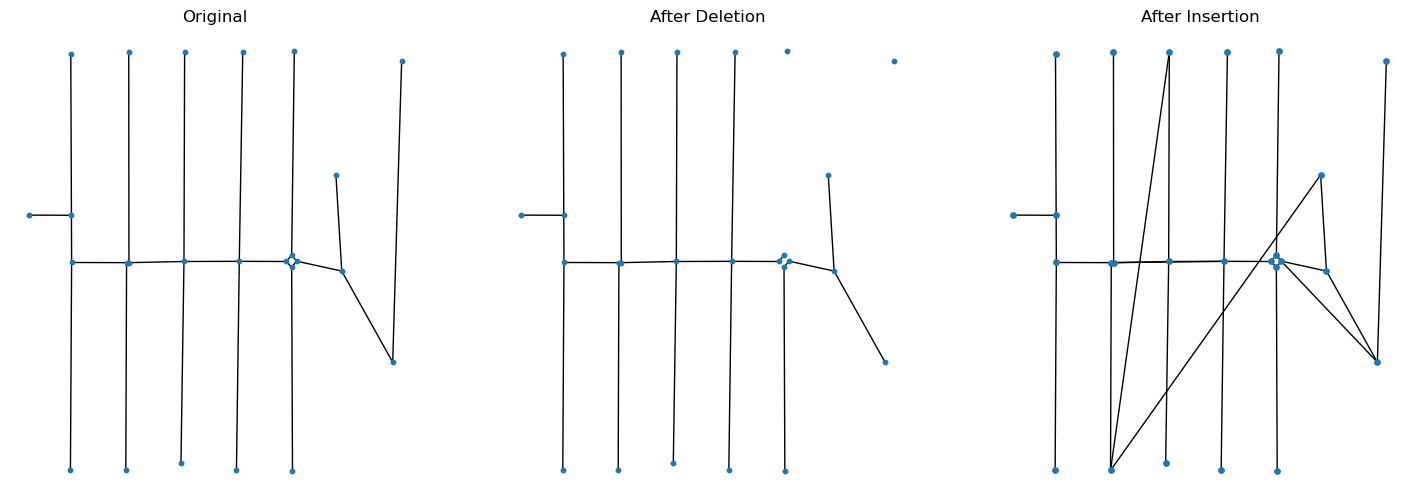

In [29]:
f, ax = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
for i, facet in enumerate(ax):
    facet.set_title(("Original", "After Deletion", "After Insertion")[i])
    facet.axis("off")
nx.draw(G, {n:[n[0], n[1]] for n in list(G.nodes)}, ax=ax[0], node_size=10)
nx.draw(G_remove, {n:[n[0], n[1]] for n in list(G_remove.nodes)}, ax=ax[1], node_size=10)
nx.draw(G_add, {n:[n[0], n[1]] for n in list(G_add.nodes)}, ax=ax[2], node_size=15)

### Save & Load

In [14]:
nx.write_gpickle(graph, 'myGraph.gpickle')

In [15]:
G = nx.read_gpickle('myGraph.gpickle')